## Classifying the probability of Malware detection

In [24]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing
import seaborn as sns
from tqdm import tqdm
import time 

In [2]:
data = pd.read_csv('training.csv')
data = data.drop(data.columns[0], axis = 1)
data.head(3)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0


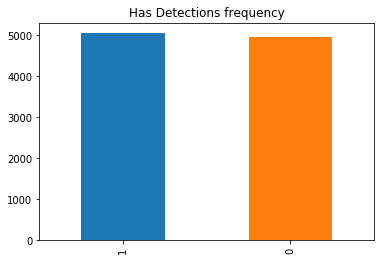

In [3]:
data['HasDetections'].value_counts().plot.bar()
plt.title('Has Detections frequency')
plt.show()

## Preprocessing the data

In [4]:
#Train_test_split
target = data['HasDetections']
dataset = data.drop ('HasDetections', axis = 1)
x_train, x_test, y_train, y_test = train_test_split (dataset, target, test_size=0.2, stratify = target)

In [5]:
train = x_train.join(y_train)
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
8420,003eba9fd57603b9327a67beb5a682a3,win8defender,1.1.15200.1,4.9.10586.1045,1.275.199.0,0,7.0,0,NaN,47238.0,...,33026.0,1,NaN,0.0,0,0,0.0,1.0,12.0,1
6143,002d09b2faf85178a63d2a2b6a8ab5ef,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1276.0,0,7.0,0,NaN,53447.0,...,62885.0,0,NaN,0.0,0,0,0.0,1.0,3.0,1
598,000467dd10b91f4f277667a42e971cf8,win8defender,1.1.15200.1,4.18.1807.18075,1.275.557.0,0,7.0,0,NaN,53447.0,...,16423.0,1,0.0,0.0,1,0,0.0,0.0,11.0,0
1151,0008894f19eafe97508896afd32f12cc,win8defender,1.1.14104.0,4.11.15063.447,1.251.115.0,0,7.0,0,1616.0,23657.0,...,33070.0,1,0.0,0.0,0,0,0.0,0.0,3.0,0
9108,00443f6321c774e78661bb57ac869158,win8defender,1.1.15200.1,4.18.1807.18075,1.275.441.0,0,7.0,0,NaN,53447.0,...,8625.0,1,NaN,0.0,0,0,0.0,1.0,3.0,1


I will preprocess data to reduce the dimensionality of the dataset based on these rules:
- Firstly, I will remove the columns whose values contain too many null values.
- Secondly, I will remove the columns whose values are too skewed, which will be uninformative for classification task.

After removing these columns, I will be working on encoding the dataset and using ML technique to predict the model. 

### Feature engineering to remove columns with a large number of null values

In [6]:
drop_columns = []
(train.isnull().sum()/train.shape[0]).sort_values(ascending=False)[0:8]

PuaMode                       0.999750
Census_ProcessorClass         0.995625
DefaultBrowsersIdentifier     0.952875
Census_IsFlightingInternal    0.830125
Census_InternalBatteryType    0.710000
Census_ThresholdOptIn         0.633875
Census_IsWIMBootEnabled       0.632625
SmartScreen                   0.358500
dtype: float64

In [7]:
#Based on the information above, I will remove columns whose null values account for more than 80% of the dataset. 
#Filling in null values of those columns are extremely hard and sometimes will distort the predictability of the model
drop_columns = ['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal']
train = train.drop (drop_columns, axis = 1)

### Feature engineer to remove columns with high skewness

In [8]:
#Measure the skewness of the dataset. Skewness level is good
skewness = pd.DataFrame([{'column': c, 'uniq': train[c].nunique(), 'skewness': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
skewness = skewness.sort_values('skewness', ascending=False)
skewness[0:15]

,column,skewness,uniq
65,Census_IsFlightsDisabled,100.000000,1
26,AutoSampleOptIn,100.000000,1
67,Census_ThresholdOptIn,100.000000,1
71,Census_IsWIMBootEnabled,100.000000,1
5,IsBeta,100.000000,1
27,SMode,99.973326,2
62,Census_IsPortableOperatingSystem,99.937500,2
33,Census_DeviceFamily,99.850000,2
31,UacLuaenable,99.349431,2
72,Census_IsVirtualDevice,99.298597,2


In [9]:
#Delete columns with high skewness
drop_columns_2 = (skewness[skewness.skewness > 99].column.tolist())
train = train.drop(drop_columns_2,axis=1)

In [10]:
#Check the number of null values in each rows
(train.isnull().sum()/train.shape[0]).sort_values(ascending=False)[0:10]

Census_InternalBatteryType               0.710000
SmartScreen                              0.358500
OrganizationIdentifier                   0.300375
CityIdentifier                           0.038375
Wdft_RegionIdentifier                    0.031000
Wdft_IsGamer                             0.031000
Census_InternalBatteryNumberOfCharges    0.029250
Census_FirmwareManufacturerIdentifier    0.019875
Census_FirmwareVersionIdentifier         0.017500
Census_OEMModelIdentifier                0.011375
dtype: float64

### Fill in null values and drop rows with na values

In [11]:
#Fill in SmartScreen na values
#Source: https://www.kaggle.com/jiegeng94/everyone-do-this-at-the-beginning
trans_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
train.replace({'SmartScreen': trans_dict}, inplace=True)
train.SmartScreen.isnull().sum()

0

In [12]:
#Fill in Census_InternalBatteryType na values
trans_dict = {'unkn': 'unknown', np.nan: 'unknown'}
train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)
train.Census_InternalBatteryType.isnull().sum()

0

In [13]:
#Fill in OrganizationIdentifier na values
train.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)
train.OrganizationIdentifier.isnull().sum()

0

In [14]:
train.dropna(inplace=True)
train.shape

(6911, 68)

In [15]:
#This value is not important for classification
train.drop('MachineIdentifier', axis=1, inplace=True)

### Encoding the categorical variables

In [16]:
#Source: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm/notebook
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
binary_variables = [c for c in train.columns if train[c].nunique() == 2]
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [17]:
#Convert the nominal values into dummy variables
dummy_data = pd.get_dummies (train[categorical_columns])
train = pd.concat ([train, dummy_data], axis = 1)
train = train.drop (categorical_columns, axis = 1)
train.head()

,IsSxsPassiveMode,HasTpm,OsSuite,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,...,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS
8420,0,1,768,1.0,1.0,2.0,29820.0,28558.0,0,4096.0,...,0,0,0,0,0,0,1,0,0,0
6143,0,1,256,1.0,1.0,2.0,305245.0,79434.0,0,3072.0,...,1,0,0,0,0,0,1,0,0,0
598,0,1,768,1.0,1.0,4.0,244198.0,201458.0,0,8192.0,...,1,0,0,0,0,0,1,0,0,0
1151,0,1,768,1.0,1.0,2.0,953869.0,938602.0,0,4096.0,...,0,0,0,0,0,0,1,0,0,0
8998,0,1,256,1.0,1.0,4.0,476940.0,227790.0,0,4096.0,...,1,0,0,0,0,0,1,0,0,0


In [18]:
train_y = train['HasDetections']
train_x = train.drop(['HasDetections'], axis = 1)

### Normalization

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 

x = train_x[true_numerical_columns].values
x_scaled = scaler.fit_transform(x)
train_x_norm = pd.DataFrame(x_scaled, columns=true_numerical_columns, index = train_x.index)
train_x[true_numerical_columns] = train_x_norm

In [20]:
train_x.head(3)

,IsSxsPassiveMode,HasTpm,OsSuite,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,...,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS
8420,0,1,768,1.0,1.0,0.032258,0.005276,0.005355,0,0.047619,...,0,0,0,0,0,0,1,0,0,0
6143,0,1,256,1.0,1.0,0.032258,0.102026,0.023225,0,0.031746,...,1,0,0,0,0,0,1,0,0,0
598,0,1,768,1.0,1.0,0.096774,0.080581,0.066086,0,0.111111,...,1,0,0,0,0,0,1,0,0,0


## Choosing hyperparameters and classification tasks

In [27]:
# # Parameter grids
# param_grid_SVM = {
#     'kernel': ['linear', 'rbf'],
#     'C': [0.001, 0.01, 0.1,0.25,0.5,0.75,1],
#     'gamma' :  [0.001, 0.01, 0.1, 1, 2, 3, "auto"]}

# param_grid_rf = {
#     'bootstrap': [True],
#     'max_depth': [50,80,100,150,200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'n_estimators': [100, 300, 500]
# }

param_grid_lr={
    "max_iter":[1000],
    "C":np.logspace(-3,3,7), 
    "solver":['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

# Classifiers
# SVM = svm.SVC()
# rf = RandomForestClassifier()
logreg=LogisticRegression() 

print("Optimal Parameters:")
# # SVM
# grid_search_SVM = GridSearchCV(estimator = SVM, param_grid = param_grid_SVM, scoring = "recall",cv=5,iid=False) 
# grid_search_SVM.fit(X, y)
# print("SVM:", grid_search_SVM.best_params_)

# # Random Forest (takes around 5 minutes)
# grid_search_forest = GridSearchCV(rf, param_grid_rf, scoring = "recall",cv=5,iid=False)
# grid_search_forest.fit(X, y)
# print("Forest:", grid_search_forest.best_params_)

# Linear Regression
grid_search_lr=GridSearchCV(estimator = logreg,param_grid = param_grid_lr, scoring = "recall",cv=5, iid=False)
grid_search_lr.fit(x,y)
print("LogReg:", grid_search_lr.best_params_)

Optimal Parameters:


KeyboardInterrupt: 

## Classification tasks

In [29]:
#Using logistic regression
from sklearn.linear_model import LogisticRegression
import time
start = time.time()
classifier = LogisticRegression(C=1000., penalty='l2', solver= 'newton-cg', max_iter=4000)
x = train_x
y = train_y
classifier.fit(x, y)
train_score = cross_val_score(classifier, x, y, cv=3, scoring='accuracy')
end = time.time()
print ('Running time for logistic regression {:.2f}'.format (end - start))
print ('Cross validation accurary is {}'.format (train_score))

KeyboardInterrupt: 

In [29]:
#Using random forest
from sklearn.ensemble import RandomForestClassifier
start = time.time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit (x,y)
train_score_rf = cross_val_score(rf, x, y, cv=3, scoring='accuracy')
end = time.time()
print ('Running time for random forest {:.2f}'.format (end - start))
print ('Cross validation accurary is {}'.format (train_score_rf))

Running time for random forest 4.16
Cross validation accurary is [0.59181897 0.59442994 0.59407666]


In [30]:
#Using SVM model
from sklearn.svm import SVC
start = time.time()
svm = SVC(gamma='auto')
svm.fit (x,y)
train_score_svm = cross_val_score(svm, x, y, cv=3, scoring='accuracy')
end = time.time()
print ('Running time for SVM {:.2f}'.format (end - start))
print ('Cross validation accurary is {}'.format (train_score_svm))

Running time for SVM 292.27
Cross validation accurary is [0.56092254 0.51087903 0.54965157]


### Perform classification on the hold-out test set

In [35]:
test = x_test.join(y_test)
test.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
3055,00165f6363b0edf849628c1fe4ee47ed,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1490.0,0,7.0,0,NaN,53447.0,...,12459.0,0,0.0,0.0,0,0,0.0,0.0,10.0,1
9024,0043be7751c043c200191980c6c301ff,win8defender,1.1.15200.1,4.18.1807.18075,1.275.981.0,0,7.0,0,NaN,47238.0,...,33041.0,1,NaN,0.0,0,0,0.0,0.0,15.0,0
4453,0020907078f31a0665d530a8da6a66c6,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,39975.0,...,7759.0,1,NaN,0.0,1,1,1.0,0.0,13.0,0
4343,001fc3addb23ca41c16b65193caf4c37,win8defender,1.1.15200.1,4.8.10240.16384,1.275.1120.0,0,7.0,0,NaN,53447.0,...,19970.0,0,0.0,0.0,0,0,0.0,1.0,11.0,0
3829,001c09595151a4deafad388379474237,win8defender,1.1.14600.4,4.12.17007.18022,1.263.490.0,0,7.0,0,NaN,59937.0,...,21628.0,1,0.0,0.0,0,0,0.0,1.0,11.0,0


### Preprocess the test set the same way that I preprocess the training set

In [36]:
test = test.drop (drop_columns, axis = 1)
test = test.drop (drop_columns_2,axis=1)

In [37]:
#Fill in SmartScreen na values
test.replace({'SmartScreen': trans_dict}, inplace=True)
test.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)
test.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)
test.dropna(inplace=True)
test.drop('MachineIdentifier', axis=1, inplace=True)

In [39]:
test_dummy_data = pd.get_dummies (test[categorical_columns])
test = pd.concat ([test, test_dummy_data], axis = 1)
test = test.drop (categorical_columns, axis = 1)

,IsSxsPassiveMode,HasTpm,OsSuite,IsProtected,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,...,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS
3055,0,1,256,1.0,1.0,2.0,476938.0,154424.0,0,4096.0,...,1,0,0,0,0,0,1,0,0,0
9024,0,1,768,1.0,1.0,2.0,29820.0,28558.0,0,4096.0,...,0,0,0,0,0,0,1,0,0,0
4453,0,1,256,1.0,1.0,4.0,244198.0,242949.0,0,8192.0,...,0,0,0,0,0,0,1,0,0,0
4343,0,1,256,1.0,1.0,2.0,476940.0,130785.0,0,2048.0,...,0,1,0,0,1,0,0,0,0,0
3829,0,1,768,0.0,1.0,2.0,476940.0,434061.0,0,2048.0,...,1,0,0,0,0,0,1,0,0,0


In [40]:
test_y = test['HasDetections']
test_x = test.drop(['HasDetections'], axis = 1)

In [43]:
x = test_x[true_numerical_columns].values
x_scaled = scaler.fit_transform(x)
test_x_norm = pd.DataFrame(x_scaled, columns=true_numerical_columns, index = test_x.index)
test_x[true_numerical_columns] = test_x_norm

In [52]:
# Get missing columns in the training test
missing_cols = set(train_x.columns ) - set(test_x.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_x[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_x = test_x[train_x.columns]

### Logistic regression testing

In [59]:
start = time.time()
test_pred = classifier.predict(test_x)
end = time.time()
print ('Running time is {:.2f}'.format (end - start))
print ('r2_score :', r2_score(test_y, test_pred))
print ('accuracy score:', accuracy_score(test_y, test_pred))
print ('roc_auc_score:', roc_auc_score(test_y, test_pred))

Running time is 0.03
r2_score : -0.6266861431658066
accuracy score: 0.5933682373472949
roc_auc_score: 0.5919073250770306


### Random forest testing

In [60]:
start = time.time()
test_pred = rf.predict(test_x)
end = time.time()
print ('Running time is {:.2f}'.format (end - start))
print ('r2_score :', r2_score(test_y, test_pred))
print ('accuracy score:', accuracy_score(test_y, test_pred))
print ('roc_auc_score:', roc_auc_score(test_y, test_pred))

Running time is 0.06
r2_score : -0.5778157440149025
accuracy score: 0.6055846422338569
roc_auc_score: 0.6053159200073646


### SVM testing

In [61]:
start = time.time()
test_pred = svm.predict(test_x)
end = time.time()
print ('Running time is {:.2f}'.format (end - start))
print ('r2_score :', r2_score(test_y, test_pred))
print ('accuracy score:', accuracy_score(test_y, test_pred))
print ('roc_auc_score:', roc_auc_score(test_y, test_pred))

Running time is 21.48
r2_score : -0.7058096465529846
accuracy score: 0.5735892961023851
roc_auc_score: 0.572621258806392
